### Defining Functions

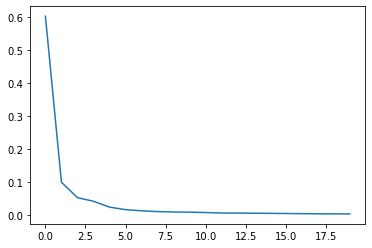

In [1]:
### Importinhg Librarires
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score,precision_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

### Principal Component analysis
def PCA(X_meaned):     
    cov_mat = np.cov(X_meaned , rowvar = False)
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index] 
    pov = sorted_eigenvalue/np.sum(sorted_eigenvalue)
    return sorted_eigenvalue, sorted_eigenvectors, pov

def pca_transformation(num_components, sorted_eigenvectors, X_meaned, mean): 
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    X_reconstructed = np.dot(eigenvector_subset,np.dot(eigenvector_subset.transpose(),X_meaned.transpose())).transpose()+mean
    return X_reconstructed


### K Nearest Neighbours

#Euclidean Distance
def eucledian(p1,p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist
 
#Function to calculate KNN
def knn_predict(x_train, y , x_input, k):
    op_labels = []
     
    #Loop through the Datapoints to be classified
    for item in x_input: 
         
        #Array to store distances
        point_dist = []
         
        #Loop through each training Data
        for j in range(len(x_train)): 
            distances = eucledian(np.array(x_train[j,:]) , item) 
            #Calculating the distance
            point_dist.append(distances) 
        point_dist = np.array(point_dist) 
         
        #Sorting the array while preserving the index
        #Keeping the first K datapoints
        dist = np.argsort(point_dist)[:k] 
         
        #Labels of the K datapoints from above
        labels = y[dist]
         
        #Majority voting
        lab = mode(labels) 
        lab = lab.mode[0]
        op_labels.append(lab)
 
    return op_labels

### Finding number of eigen vectors to use using elbow method
features = np.load('Data/features.npy')
labels = np.load('Data/labels.npy')
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42, shuffle = True)

X_meaned = X_train - np.mean(X_train, axis = 0)
sorted_eigenvalue, sorted_eigenvectors, info_captured = PCA(X_meaned)
plt.plot(info_captured[0:20])

### Seperating data for each class

In [2]:
df = pd.DataFrame(X_train)
df['label'] = y_train

records =[]
for i in range(df['label'].nunique()):
    records.append(df[df['label']==i].to_numpy())

### eigen vectors for each class

In [3]:
eigen_vectors =[]
means = []
for i in range(len(records)):
    X_train = records[i][:,0:-1]
    mean = np.mean(X_train, axis = 0)
    X_train_meaned = X_train - mean
    _ , sorted_eigenvectors, _ = PCA(X_train_meaned)
    means.append(mean)
    eigen_vectors.append(sorted_eigenvectors)

In [4]:
def classification(X_test, means, eigenvectors):
    loss = []
    for i in range(len(eigenvectors)):
        X_test_meaned = X_test - means[i]
        X_test_reconstructed = pca_transformation(2,eigenvectors[i],X_test_meaned,means[i])
        loss.append(np.square(X_test - X_test_reconstructed).mean(axis=1))
    loss = np.array(loss)
    labels = np.argmin(loss , axis =0)
    return labels

In [5]:
pred_labels = np.array(classification(X_test, means, eigen_vectors))

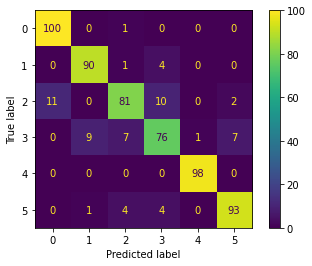

Test Set precison:  0.8949486285124583
Test Set Accuracy:  0.8966666666666666
Test Set Recall Score:  0.8966666666666666
Test Set F1 Score:  0.8948654819768748


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


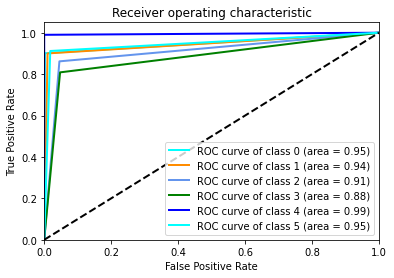

In [9]:
def test(test_labels,test_pred):
    test_labels = np.array(test_labels)
    test_pred = np.array(test_pred)
    cm = confusion_matrix(test_pred, test_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print('Test Set precison: ', precision_score(test_pred, test_labels,average='weighted' ))  
    print('Test Set Accuracy: ', accuracy_score(test_pred, test_labels))    
    print('Test Set Recall Score: ', recall_score(test_pred, test_labels, average='weighted'))
    print('Test Set F1 Score: ', f1_score(test_pred, test_labels, average='weighted')) 

    y_test = label_binarize(test_labels, classes=list(range(10)))
    y_score = label_binarize(test_pred, classes=list(range(10)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = itertools.cycle(["aqua", "darkorange", "cornflowerblue", 'green', 'blue','cyan'])
    for i, color in zip(range(6), colors):
        plt.plot(fpr[i],tpr[i],color=color, lw=2, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

test(y_test,pred_labels)